In [42]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import interpolate
from sklearn.utils import shuffle

In [43]:
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from tensorflow.python.client import device_lib
physical_gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

In [44]:
#Setting up training and testing data:
mean_1 = [1, 1, 1, 1, 1]
cov_1 = [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1,0], [0, 0, 0, 0, 1]]

mean_2 = [0, 0, 0, 0, 0]
cov_2 = [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1,0], [0, 0, 0, 0, 1]]

mean_3 = [-1, -1, -1, -1, -1]
cov_3 = [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1,0], [0, 0, 0, 0, 1]]


x_1 = np.random.multivariate_normal(mean_1, cov_1, size=1000000)
y_1 = np.random.multivariate_normal(mean_1, cov_1, size=100000)

x_2 = np.random.multivariate_normal(mean_2, cov_2, size=1000000)
y_2 = np.random.multivariate_normal(mean_2, cov_2, size=100000)

x_3 = np.random.multivariate_normal(mean_3, cov_3, size=1000000)
y_3 = np.random.multivariate_normal(mean_3, cov_3, size=100000)


In [45]:
print(x_1[0])

[ 0.68738941 -0.37905958  1.92668057  2.55586336  1.75381035]


Distribution of the raw samples

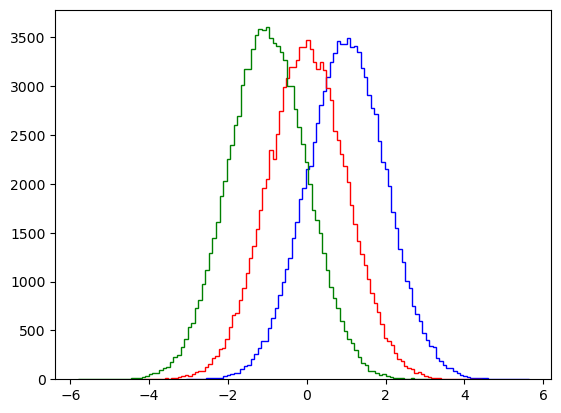

In [46]:
plt.hist(y_1[:,0], bins = 100, edgecolor = 'b', histtype = 'step')
plt.hist(y_2[:,0], bins = 100, edgecolor = 'r', histtype = 'step')
plt.hist(y_3[:,0], bins = 100, edgecolor = 'g', histtype = 'step')
plt.show()

In [62]:
#Preparing three samples
n_samples = 3
n_dom = 10000 #Number of signal samples in dominant class
n_sub = 2500

sample_1_1_train = x_1[0:n_dom]
#Using one-hot encoding here
true_label_sample_1_1_train = np.tile(np.array([1., 0., 0.]), 
                                      np.shape(sample_1_1_train)[0]).reshape(np.shape(sample_1_1_train)[0],n_samples)

sample_1_2_train = x_2[0:n_sub]
true_label_sample_1_2_train = np.tile(np.array([0., 1., 0.]), 
                                      np.shape(sample_1_2_train)[0]).reshape(np.shape(sample_1_2_train)[0],n_samples)
sample_1_3_train = x_3[0:n_sub]
true_label_sample_1_3_train = np.tile(np.array([0., 0., 1.]), 
                                      np.shape(sample_1_3_train)[0]).reshape(np.shape(sample_1_3_train)[0],n_samples)

sample_2_1_train = x_1[n_dom:n_sub+n_dom]
#Using one-hot encoding here
true_label_sample_2_1_train = np.tile(np.array([1., 0., 0.]), 
                                      np.shape(sample_2_1_train)[0]).reshape(np.shape(sample_2_1_train)[0],n_samples)

sample_2_2_train = x_2[n_sub:n_sub + n_dom]
true_label_sample_2_2_train = np.tile(np.array([0., 1., 0.]), 
                                      np.shape(sample_2_2_train)[0]).reshape(np.shape(sample_2_2_train)[0],n_samples)
sample_2_3_train = x_3[n_sub:n_sub+n_sub]
true_label_sample_2_3_train = np.tile(np.array([0., 0., 1.]), 
                                      np.shape(sample_2_3_train)[0]).reshape(np.shape(sample_2_3_train)[0],n_samples)

sample_3_1_train = x_1[n_sub+n_dom:n_sub+n_sub+n_dom]
#Using one-hot encoding here
true_label_sample_3_1_train = np.tile(np.array([1., 0., 0.]), 
                                      np.shape(sample_3_1_train)[0]).reshape(np.shape(sample_3_1_train)[0],n_samples)

sample_3_2_train = x_2[n_sub+n_dom:n_sub+n_sub+n_dom]
true_label_sample_3_2_train = np.tile(np.array([0., 1., 0.]), 
                                      np.shape(sample_3_2_train)[0]).reshape(np.shape(sample_3_2_train)[0],n_samples)
sample_3_3_train = x_3[n_sub+n_sub:n_sub+n_sub+n_dom]
true_label_sample_3_3_train = np.tile(np.array([0., 0., 1.]), 
                                      np.shape(sample_3_3_train)[0]).reshape(np.shape(sample_3_3_train)[0],n_samples)






In [63]:
x_test = np.concatenate((y_1,y_2,y_3))
y_test_1 = np.tile(np.array([1., 0., 0.]), 
            np.shape(y_1)[0]).reshape(np.shape(y_1)[0],n_samples)
y_test_2 = np.tile(np.array([0., 1., 0.]), 
            np.shape(y_2)[0]).reshape(np.shape(y_2)[0],n_samples)
y_test_3 = np.tile(np.array([0., 0., 1.]), 
            np.shape(y_3)[0]).reshape(np.shape(y_3)[0],n_samples)
y_test = np.concatenate((y_test_1, y_test_2, y_test_3))

In [64]:
y_test = np.argmax(y_test, axis = 1)

In [65]:
print(y_test)

[0 0 0 ... 2 2 2]


One versus all

In [66]:
rng = np.random.default_rng()
x_train_1 = np.concatenate((sample_1_1_train, sample_1_2_train, sample_1_3_train))
y_train_1 = np.tile(np.array([1., 0., 0.]), 
            np.shape(x_train_1)[0]).reshape(np.shape(x_train_1)[0],n_samples)
true_label_1 = np.concatenate((true_label_sample_1_1_train, true_label_sample_1_2_train, 
                               true_label_sample_1_3_train))
indices_1 = rng.permutation(np.shape(x_train_1)[0])

x_shuffle_1 = x_train_1[indices_1]
y_shuffle_1 = y_train_1[indices_1]
true_label_shuffle_1 = true_label_1[indices_1]

x_train_2 = np.concatenate((sample_2_1_train, sample_2_2_train, sample_2_3_train))
y_train_2 = np.tile(np.array([0., 1., 0.]), 
            np.shape(x_train_2)[0]).reshape(np.shape(x_train_2)[0],n_samples)
true_label_2 = np.concatenate((true_label_sample_2_1_train, true_label_sample_2_2_train, 
                               true_label_sample_2_3_train))
indices_2 = rng.permutation(np.shape(x_train_2)[0])

x_shuffle_2 = x_train_2[indices_2]
y_shuffle_2 = y_train_2[indices_2]
true_label_shuffle_2 = true_label_2[indices_2]

x_train_3 = np.concatenate((sample_3_1_train, sample_3_2_train, sample_3_3_train))
y_train_3 = np.tile(np.array([0., 0., 1.]), 
            np.shape(x_train_3)[0]).reshape(np.shape(x_train_3)[0],n_samples)
true_label_3 = np.concatenate((true_label_sample_3_1_train, true_label_sample_3_2_train, 
                               true_label_sample_3_3_train))
indices_3 = rng.permutation(np.shape(x_train_3)[0])

x_shuffle_3 = x_train_3[indices_3]
y_shuffle_3 = y_train_3[indices_3]
true_label_shuffle_3 = true_label_3[indices_3]


Distribution of the mixed samples

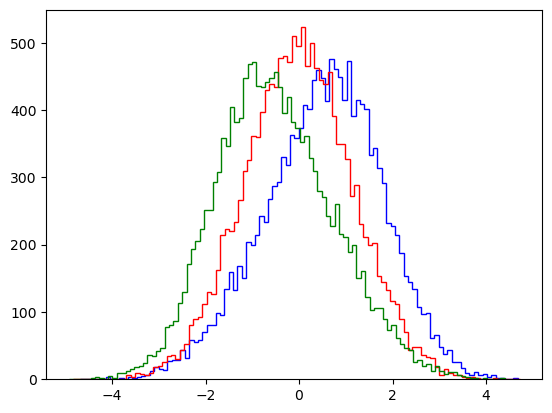

In [67]:
plt.hist(x_train_1[:,0], bins = 100, edgecolor = 'b', histtype = 'step')
plt.hist(x_train_2[:,0], bins = 100, edgecolor = 'r', histtype = 'step')
plt.hist(x_train_3[:,0], bins = 100, edgecolor = 'g', histtype = 'step')
plt.show()

Code from Feng-Yang:

In [68]:
def build_model(input_dim):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(16, input_dim=input_dim, activation='relu'))
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.Dense(3, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

In [69]:
x_train = np.concatenate((x_shuffle_1, x_shuffle_2, x_shuffle_3))
y_train = np.concatenate((y_shuffle_1, y_shuffle_2, y_shuffle_3))
true_label_train = np.concatenate((true_label_shuffle_1, true_label_shuffle_2, true_label_shuffle_3))

y_train = np.argmax(y_train, axis = 1)
true_label_train = np.argmax(true_label_train, axis = 1)

indices_train = rng.permutation(np.shape(x_train)[0])

x_train = x_train[indices_train]
y_train = y_train[indices_train]
true_label_train = true_label_train[indices_train]


In [70]:
model = build_model(x_train.shape[1])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, patience=10)
history = model.fit(x_train, y_train, validation_split = 0.2, epochs=50, batch_size=1024, verbose=1, 
                    callbacks=[
                              early_stopping,
                               ])

Train on 36000 samples, validate on 9000 samples
Epoch 1/50
36000/36000 [==============================] - 0s 13us/sample - loss: 1.0138 - accuracy: 0.5181 - val_loss: 0.9712 - val_accuracy: 0.5697
Epoch 2/50
36000/36000 [==============================] - 0s 5us/sample - loss: 0.9639 - accuracy: 0.5736 - val_loss: 0.9630 - val_accuracy: 0.5750
Epoch 3/50
36000/36000 [==============================] - 0s 5us/sample - loss: 0.9582 - accuracy: 0.5765 - val_loss: 0.9568 - val_accuracy: 0.5769
Epoch 4/50
36000/36000 [==============================] - 0s 5us/sample - loss: 0.9551 - accuracy: 0.5779 - val_loss: 0.9557 - val_accuracy: 0.5777
Epoch 5/50
36000/36000 [==============================] - 0s 5us/sample - loss: 0.9538 - accuracy: 0.5765 - val_loss: 0.9575 - val_accuracy: 0.5724
Epoch 6/50
36000/36000 [==============================] - 0s 5us/sample - loss: 0.9532 - accuracy: 0.5781 - val_loss: 0.9564 - val_accuracy: 0.5760
Epoch 7/50
36000/36000 [==============================] - 0s 5

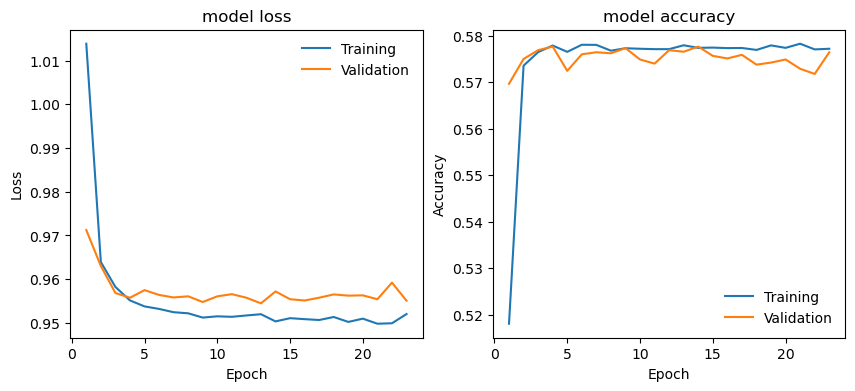

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

x = range(1, len(history.history['loss']) + 1)

ax[0].plot(x, history.history['loss'], label='Training')
ax[0].plot(x, history.history['val_loss'], label='Validation')

ax[0].legend(frameon=False)
ax[0].set_title(f'model loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(x, history.history['accuracy'], label='Training')
ax[1].plot(x, history.history['val_accuracy'], label='Validation')

ax[1].legend(frameon=False)
ax[1].set_title(f'model accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
plt.show()

In [72]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"One-vs-All Test Accuracy: {accuracy * 100:.2f}%")

One-vs-All Test Accuracy: 82.05%


One versus Rest strategy

In [73]:
def build_model_ovr(input_dim):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(16, input_dim=input_dim, activation='relu'))
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

Train on 36000 samples, validate on 9000 samples
Epoch 1/50
36000/36000 [==============================] - 1s 15us/sample - loss: 0.6037 - accuracy: 0.6831 - val_loss: 0.5633 - val_accuracy: 0.7234
Epoch 2/50
36000/36000 [==============================] - 0s 5us/sample - loss: 0.5516 - accuracy: 0.7350 - val_loss: 0.5594 - val_accuracy: 0.7258
Epoch 3/50
36000/36000 [==============================] - 0s 5us/sample - loss: 0.5486 - accuracy: 0.7359 - val_loss: 0.5576 - val_accuracy: 0.7273
Epoch 4/50
36000/36000 [==============================] - 0s 5us/sample - loss: 0.5475 - accuracy: 0.7361 - val_loss: 0.5561 - val_accuracy: 0.7278
Epoch 5/50
36000/36000 [==============================] - 0s 5us/sample - loss: 0.5474 - accuracy: 0.7368 - val_loss: 0.5565 - val_accuracy: 0.7286
Epoch 6/50
36000/36000 [==============================] - 0s 5us/sample - loss: 0.5472 - accuracy: 0.7360 - val_loss: 0.5554 - val_accuracy: 0.7279
Epoch 7/50
36000/36000 [==============================] - 0s 5

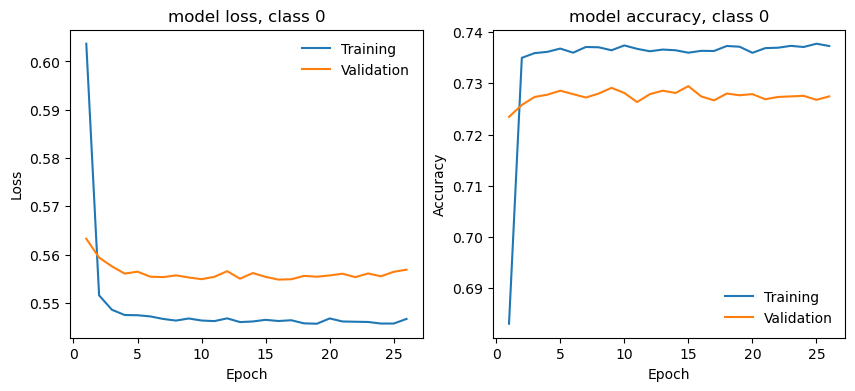

Train on 36000 samples, validate on 9000 samples
Epoch 1/50
36000/36000 [==============================] - 1s 15us/sample - loss: 0.6164 - accuracy: 0.6481 - val_loss: 0.5863 - val_accuracy: 0.6824
Epoch 2/50
36000/36000 [==============================] - 0s 5us/sample - loss: 0.5928 - accuracy: 0.6824 - val_loss: 0.5855 - val_accuracy: 0.7016
Epoch 3/50
36000/36000 [==============================] - 0s 5us/sample - loss: 0.5909 - accuracy: 0.6908 - val_loss: 0.5829 - val_accuracy: 0.7012
Epoch 4/50
36000/36000 [==============================] - 0s 5us/sample - loss: 0.5900 - accuracy: 0.6920 - val_loss: 0.5828 - val_accuracy: 0.7027
Epoch 5/50
36000/36000 [==============================] - 0s 5us/sample - loss: 0.5891 - accuracy: 0.6938 - val_loss: 0.5832 - val_accuracy: 0.7014
Epoch 6/50
36000/36000 [==============================] - 0s 5us/sample - loss: 0.5891 - accuracy: 0.6926 - val_loss: 0.5835 - val_accuracy: 0.7021
Epoch 7/50
36000/36000 [==============================] - 0s 5

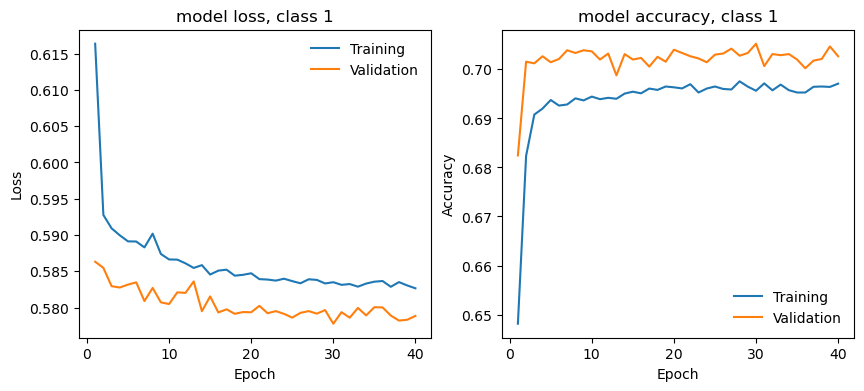

Train on 36000 samples, validate on 9000 samples
Epoch 1/50
36000/36000 [==============================] - 1s 15us/sample - loss: 0.5856 - accuracy: 0.7066 - val_loss: 0.5572 - val_accuracy: 0.7342
Epoch 2/50
36000/36000 [==============================] - 0s 5us/sample - loss: 0.5532 - accuracy: 0.7362 - val_loss: 0.5513 - val_accuracy: 0.7366
Epoch 3/50
36000/36000 [==============================] - 0s 5us/sample - loss: 0.5494 - accuracy: 0.7368 - val_loss: 0.5501 - val_accuracy: 0.7358
Epoch 4/50
36000/36000 [==============================] - 0s 5us/sample - loss: 0.5487 - accuracy: 0.7366 - val_loss: 0.5500 - val_accuracy: 0.7378
Epoch 5/50
36000/36000 [==============================] - 0s 5us/sample - loss: 0.5478 - accuracy: 0.7384 - val_loss: 0.5498 - val_accuracy: 0.7362
Epoch 6/50
36000/36000 [==============================] - 0s 5us/sample - loss: 0.5471 - accuracy: 0.7390 - val_loss: 0.5497 - val_accuracy: 0.7367
Epoch 7/50
36000/36000 [==============================] - 0s 5

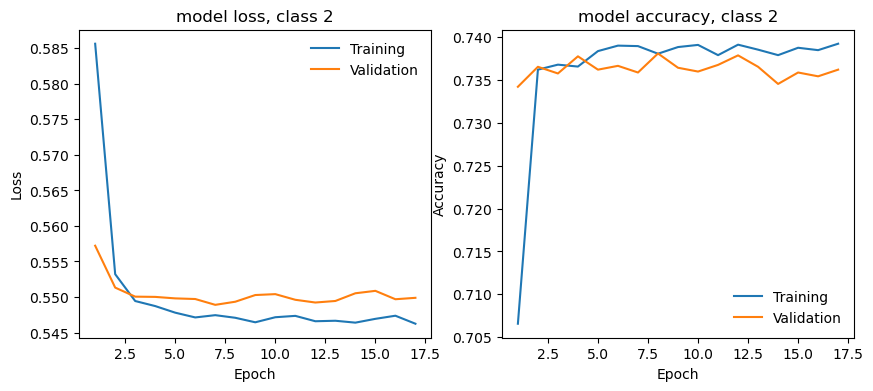

In [74]:
models = []
for class_index in range(n_samples):
    y_train_bin = np.where(y_train == class_index, 1, 0)
    model_2 = build_model_ovr(x_train.shape[1])
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, patience=10)
    history_2 = model_2.fit(x_train, y_train_bin, validation_split = 0.2, epochs=50, batch_size=1024, verbose=1, 
                    callbacks=[
                              early_stopping,
                               ])
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    x = range(1, len(history_2.history['loss']) + 1)

    ax[0].plot(x, history_2.history['loss'], label='Training')
    ax[0].plot(x, history_2.history['val_loss'], label='Validation')

    ax[0].legend(frameon=False)
    ax[0].set_title(f'model loss, class {class_index}')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(x, history_2.history['accuracy'], label='Training')
    ax[1].plot(x, history_2.history['val_accuracy'], label='Validation')

    ax[1].legend(frameon=False)
    ax[1].set_title(f'model accuracy, class {class_index}')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    plt.show()
    
    models.append(model_2)

In [75]:
# Making predictions using the OvR strategy
def predict_ovr(models, X_test):
    predictions = np.zeros((X_test.shape[0], len(models)))
    
    # Predict using each model
    for idx, model in enumerate(models):
        pred = model.predict(X_test)
        predictions[:, idx] = pred.flatten()
    
    # The final class is the one with the highest confidence score
    return np.argmax(predictions, axis=1)

# Get final predictions
final_predictions = predict_ovr(models, x_test)

# Calculate accuracy
accuracy = np.mean(final_predictions == y_test)
print(f"One-vs-Rest Test Accuracy: {accuracy * 100:.2f}%")

One-vs-Rest Test Accuracy: 82.04%
